### Постановка задачи

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

### Input

In [68]:
import numpy as np
import pandas as pd
import re
import copy

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import os
import sys
module_path = os.path.abspath(os.path.join('C:/Users/alex0/Documents/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import import_ipynb
from DS_modules import Models as mdl
from DS_modules import data_cleaning, data_preparation, EDA


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
np.warnings.filterwarnings('ignore')

In [69]:
HOME_OWNERSHIP = "Home Ownership"
ANNUAL_INCOME = "Annual Income"
YEARS_IN_CURRENT_JOB = "Years in current job"
TAX_LINES = "Tax Liens"
NUMBER_OF_OPEN_ACCOUNTS = "Number of Open Accounts"
YEARS_OF_CREDIT_HISTORY = "Years of Credit History"
MAXIMUM_OPEN_CREDIT = "Maximum Open Credit"
NUMBER_OF_CREDIT_PROBLEMS = "Number of Credit Problems"
MONTHS_SINCE_LAST_DELINQUENT = "Months since last delinquent"
BANKRPUTCIES = "Bankruptcies"
PURPOSE = "Purpose"
TERM = "Term"
CURRENT_LOAN_AMOUNT = "Current Loan Amount"
CURRENT_CREDIT_BALANCE = "Current Credit Balance"
MONTHLY_DEBT = "Monthly Debt"
CREDIT_SCORE = "Credit Score"
CREDIT_DEFAULT = "Credit Default"

### Функции

In [70]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [71]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [72]:
def my_rfr(input_train, input_valid, input_need_predict, target_col, scale):
    #Создаю копии полученных данных
    train = copy.deepcopy(input_train)
    valid = copy.deepcopy(input_valid)
    need_predict = copy.deepcopy(input_need_predict)
    if (scale):
        print("Масштабирую данные")
        scaler = StandardScaler()
        train_scaler = scaler.fit_transform(train)
        train = pd.DataFrame(train_scaler, columns=train.columns)
        valid_scaler = scaler.fit_transform(valid)
        valid = pd.DataFrame(valid_scaler, columns=valid.columns)
        
    
    #Создаю регрессионную модель
    model = RandomForestRegressor(n_estimators=1000, max_depth=120, max_features=input_train.shape[1]-1, n_jobs=-1, random_state=42, verbose=1)
    train_target = train.pop(target_col) #Отделяю целевое значение
    model.fit(train, train_target) #Обучаю модель
    pred_train = model.predict(train)
    print(f"r2 на учебной выборке: {r2_score(train_target, pred_train)}")
    if (type(valid) != bool):
        print(f"Произвожу валидацию")
        valid_target = valid.pop(target_col)
        pred_valid = model.predict(valid)
        print(f"r2 на валидационной выборке: {r2_score(valid_target, pred_valid)}")

    
    if (type(need_predict) != bool):
        print(f"Прогнозирую {target_col}")
        need_predict.pop(target_col)
        print(need_predict.shape)
        return model.predict(need_predict)

In [73]:
# Приведение к числовому типу признака "Home Ownership"
def preprocess_home_ownership(df, col):
    df.loc[df[col]=='Have Mortgage', col] = 'Home Mortgage'
    df, new_cols = data_preparation.do_cat_le(df, [col])
    return df

In [74]:
def preprocess_annual_income(df, col):
#    df.loc[df[col].isnull(), col] = df[col].mean()
    df.loc[df[ANNUAL_INCOME]> 5000000, ANNUAL_INCOME] = float('NaN')
    return df

In [75]:
# Приведение к int типу поля "Years in current job"
def preprocess_years_in_current_job(df, col):
    result_array = []
    values = df[col].values
    for i in values:
        if type(i) is str:
            temp = int(re.search(r'\d+', i).group())
            result_array.append(temp)
        else:
            result_array.append(i)
    df[col] = result_array
    return df

In [76]:
def preprocess_bankruptcies(df, col):
    df.loc[df[col].isnull(), col] = 0
    return df

In [77]:
# Приведение к числовому типу признака "Term"
def term_to_num(term):
    result_array = []
    for i in term:
        if i == "Short Term":
            result_array.append(0)
        else:
            result_array.append(1)
    return result_array

In [78]:
def preprocess_purpose(df, col):
    df, new_cols = data_preparation.do_cat_le(df, [col])
    print(new_cols)
    return df

In [79]:
def preprocess_term(df, col):
    return pd.get_dummies(df, prefix=[col[0:3]], columns=[col])

In [80]:
def preprocess_data(df):
    df = preprocess_home_ownership(df, HOME_OWNERSHIP)
    df = preprocess_annual_income(df, ANNUAL_INCOME)
    df = preprocess_years_in_current_job(df, YEARS_IN_CURRENT_JOB)
    df = preprocess_bankruptcies(df, BANKRPUTCIES)
    df = preprocess_purpose(df, PURPOSE)
    df = preprocess_term(df, TERM)
    df.info()
    return df

### Загрузка данных

In [81]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'test.csv'

In [82]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Обработка пропусков 

In [83]:
df = preprocess_data(df)
df_test = preprocess_data(df_test)

{'le_Purpose'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5899 non-null   float64
 1   Years in current job          7129 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  3419 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Current Loan Amount           7500 non-null   float64
 10  Current Credit Balance        7500 non-null   float64
 11  Monthly Debt                  7500 non-null   float64
 12  Credit Score                  5943 non-null   f

In [84]:
# Убираем 'Months since last delinquent' т.к. имеется более 4000 пропусков.
df = df.drop('Months since last delinquent',1)
df = df.drop('Ter_Short Term', 1)
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

In [85]:
df = data_cleaning.fill_nan_with_mode(df, ['Credit Score', 'Years in current job'])
df_test = data_cleaning.fill_nan_with_mode(df_test, ['Credit Score', 'Years in current job'])

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual Income              5899 non-null   float64
 1   Years in current job       7500 non-null   float64
 2   Tax Liens                  7500 non-null   float64
 3   Number of Open Accounts    7500 non-null   float64
 4   Years of Credit History    7500 non-null   float64
 5   Maximum Open Credit        7500 non-null   float64
 6   Number of Credit Problems  7500 non-null   float64
 7   Bankruptcies               7500 non-null   float64
 8   Current Loan Amount        7500 non-null   float64
 9   Current Credit Balance     7500 non-null   float64
 10  Monthly Debt               7500 non-null   float64
 11  Credit Score               7500 non-null   float64
 12  Credit Default             7500 non-null   int64  
 13  le_Home Ownership          7500 non-null   int32

**Заполняем пропуски в "Annual Income" используя регрессию**

In [87]:
df_temp = df[['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
        'Credit Default', 'le_Home Ownership']].copy()



#отделяю значения которые надо прогнозировать
annual_income_predict = df_temp.loc[df_temp[ANNUAL_INCOME].isnull()] 

#отделяю значения которые буду использовать при обучении
annual_income_train = df_temp.loc[df_temp[ANNUAL_INCOME] > 0] 

annual_income_predictions = my_rfr(annual_income_train, False, annual_income_predict, ANNUAL_INCOME, False)
print(annual_income_predictions)
df.loc[df_temp[ANNUAL_INCOME].isnull(), ANNUAL_INCOME] = annual_income_predictions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


r2 на учебной выборке: 0.9231614295546746
Прогнозирую Annual Income
(1601, 11)


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[1098176.763 1013707.342 1473143.625 ...  944600.333 1998914.285
  824184.869]


In [88]:
df_temp = df_test[['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
        'le_Home Ownership']].copy()



#отделяю значения которые надо прогнозировать
annual_income_predict = df_temp.loc[df_temp[ANNUAL_INCOME].isnull()] 

#отделяю значения которые буду использовать при обучении
annual_income_train = df_temp.loc[df_temp[ANNUAL_INCOME] > 0] 

annual_income_predictions = my_rfr(annual_income_train, False, annual_income_predict, ANNUAL_INCOME, False)
print(annual_income_predictions)
df_test.loc[df_temp[ANNUAL_INCOME].isnull(), ANNUAL_INCOME] = annual_income_predictions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


r2 на учебной выборке: 0.9184325443028027
Прогнозирую Annual Income
(527, 10)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[ 601113.412  669993.2   1647042.968 1520910.366 1474554.527 1030043.656
 1284199.892  736261.362 2085884.98  1500419.474 3230826.614  920741.653
 1155394.313 1414117.997 1349209.456 1663906.779 1059779.53  1009485.656
 1066035.356  942202.267  989015.151 1376870.644  740892.916 1054795.697
 1362955.918 1436657.906 1515769.897 1200850.806 1204762.982 2234389.379
 1036835.681 1630344.856  755024.508 1623166.77  1841614.007 2307247.14
 1470101.668  638623.991 2431062.369 1273835.905 1487339.836 1140941.241
  783872.987 1522154.847 1521152.597 1154986.573 2696075.015  694664.776
 1888999.342 3618120.448 1306549.858 1648775.407 1293199.584 1425683.468
 1186447.818 1615495.767 1142187.014 1740985.675  994137.57  1069221.656
 1342345.706 1526341.06  1076540.456 2309790.043 2009407.662 1166322.695
  745485.273 1150464.877 1113322.765 1274232.34  1282886.232 2629837.671
 1544826.939 1973323.166  962780.331 1523662.288 1914801.456 1726338.689
 1463617.956 1301463.653  996152.672 2051505.278 181

### Обработка выбросов

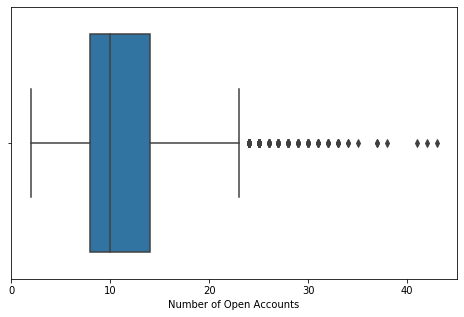

In [89]:
sns.boxplot(df[NUMBER_OF_OPEN_ACCOUNTS])

In [90]:
df.loc[df[NUMBER_OF_OPEN_ACCOUNTS] > 25, NUMBER_OF_OPEN_ACCOUNTS] = df_test[NUMBER_OF_OPEN_ACCOUNTS].mode()[0]
df_test.loc[df[NUMBER_OF_OPEN_ACCOUNTS] > 25, NUMBER_OF_OPEN_ACCOUNTS] = df_test[NUMBER_OF_OPEN_ACCOUNTS].mode()[0]

### Анализ данных

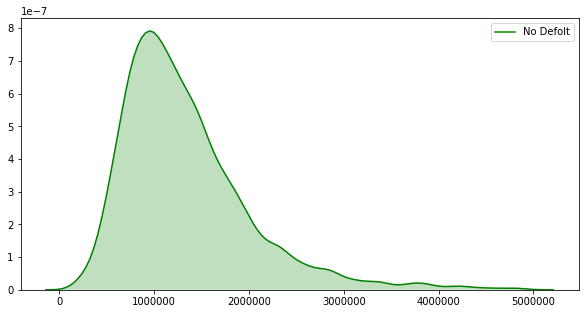

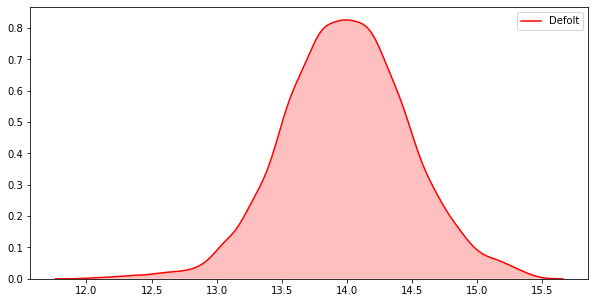

In [91]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df['Annual Income'], shade=True, label='No Defolt', color='g')
plt.show()
plt.figure(figsize=(10, 5))
sns.kdeplot(np.log(df['Annual Income']), shade=True, label='Defolt', color='r')
plt.show()

In [92]:
df[ANNUAL_INCOME] = np.log(df[ANNUAL_INCOME])
df_test[ANNUAL_INCOME] = np.log(df_test[ANNUAL_INCOME])

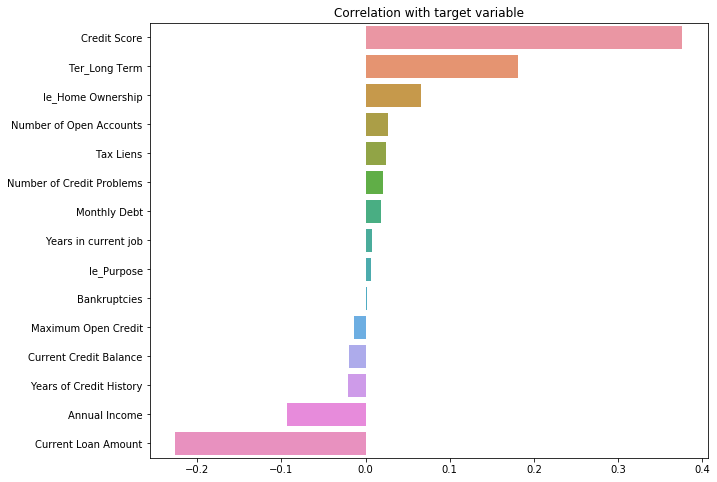

In [93]:
EDA.show_corr_bars(df, BASE_FEATURE_NAMES ,TARGET_NAME)

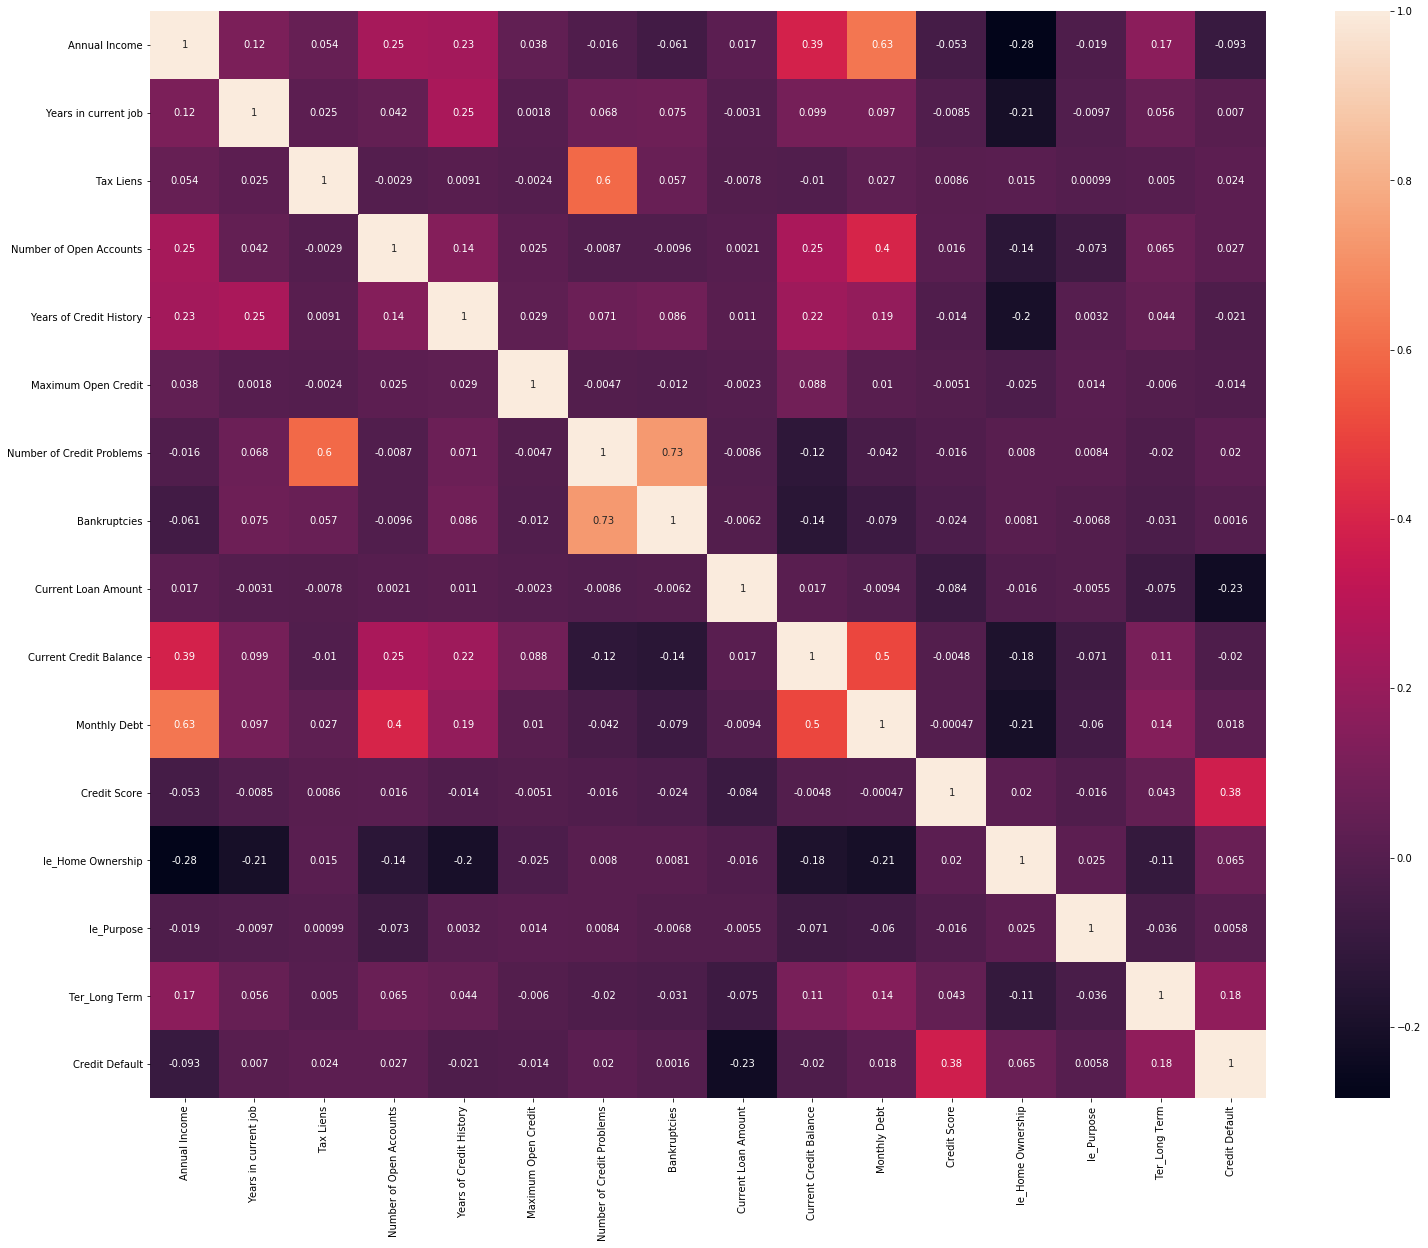

In [94]:
_data = BASE_FEATURE_NAMES.copy()
_data.append(TARGET_NAME)
EDA.show_heatmap(df, _data, True)

### Отбор признаков

In [95]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                    'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                    'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['le_Purpose', 'Ter_Long Term', 'le_Home Ownership']


### Подготовка признаков

In [96]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

le_Purpose           category
Ter_Long Term        category
le_Home Ownership    category
dtype: object

In [97]:
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

In [98]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка таргетного класса

In [99]:
df_for_balancing_f = pd.concat([X, y], axis=1)
df_balanced_f = balance_df_by_target(df_for_balancing_f, TARGET_NAME)

In [100]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

(array([3771.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2958.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

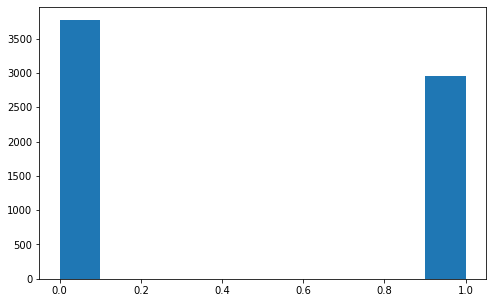

In [101]:
plt.hist(df_balanced[TARGET_NAME])

In [102]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Подбор моделей

In [103]:
model_tester = mdl.ModelTester(X, y, cat=CAT_FEATURE_NAMES)

In [104]:
# #model_tester.test_adaboost_class()
# model_tester.test_catb_class()
# model_tester.test_extratrees_class()
# model_tester.test_gb_class()
#model_tester.test_rf_class()
# model_tester.test_xgb_class()

###  Настройка гиперпараметров

In [105]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
# params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200],
#           'max_depth':[3, 5, 7]}
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [106]:
# rs = RandomizedSearchCV(LogisticRegression(), params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X, y)
# print(rs.best_params_)
# print(rs.best_score_)

### Обучение и оценка финальной модели

In [107]:
model_lr = LogisticRegression(solver='saga', l1_ratio='none', penalty='l1', random_state=21)

model_catb = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21,
                                      cat_features=CAT_FEATURE_NAMES, l2_leaf_reg=10)

In [108]:
final_model = VotingClassifier([('LR', model_lr), ('CATC', model_catb)], voting='soft', weights=[1,2])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3771
           1       0.75      0.57      0.65      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.71      0.71      6729
weighted avg       0.73      0.73      0.72      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1616
           1       0.56      0.52      0.54       634

    accuracy                           0.75      2250
   macro avg       0.69      0.68      0.68      2250
weighted avg       0.74      0.75      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1354  262
1                304  330


### Выбор порога вероятности для определения класса

In [109]:
y_test_pred_probs = final_model.predict_proba(X_test)

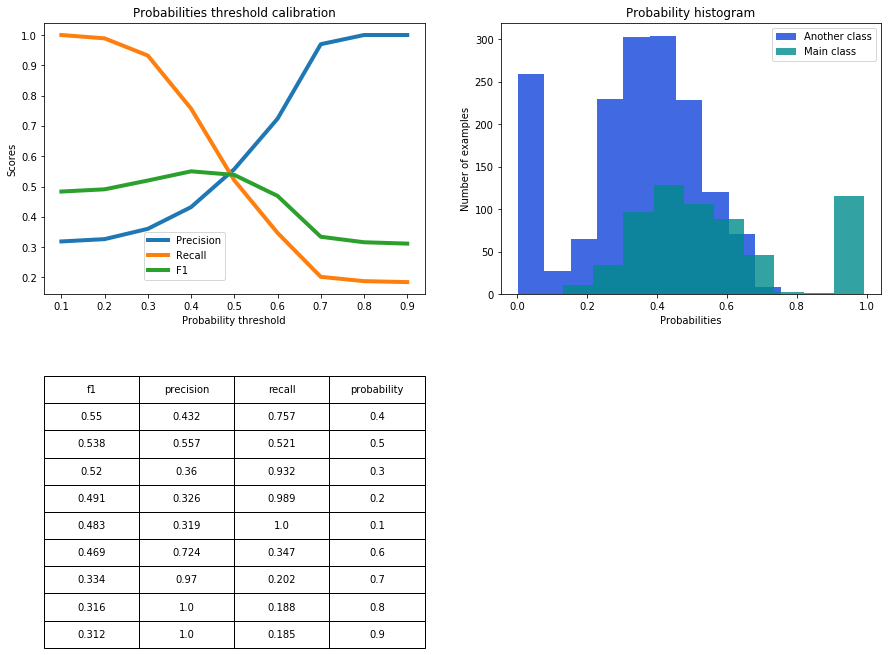

In [110]:
EDA.show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [120]:
y_p = np.array(y_test_pred_probs[:,1] > 0.4).astype('int')
get_classification_report(y_train, y_train_pred, y_test, y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3771
           1       0.75      0.57      0.65      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.71      0.71      6729
weighted avg       0.73      0.73      0.72      6729

TEST

              precision    recall  f1-score   support

           0       0.86      0.61      0.72      1616
           1       0.43      0.76      0.55       634

    accuracy                           0.65      2250
   macro avg       0.65      0.68      0.63      2250
weighted avg       0.74      0.65      0.67      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               985  631
1               154  480


### Обучение модели на всех данных

In [121]:
_X = df_balanced_f.drop(columns=TARGET_NAME)
_y = df_balanced_f[TARGET_NAME]

final_model.fit(_X, _y)

VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio='none', max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=21, solver='saga',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('CATC',
                              <catboost.core.CatBoostClassifier object at 0x000002C58C631388>)],
                 flatten_transform=True, n_jobs=None, voting='soft',
                 weights=[1, 2])

### Подготовка 'test' данных

In [122]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            2500 non-null   int64  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Current Loan Amount           2500 non-null   float64
 11  Current Credit Balance        2500 non-null   float64
 12  Monthly Debt                  2500 non-null   float64
 13  Cre

In [123]:
for colname in CAT_FEATURE_NAMES:
    df_test[colname] = pd.Categorical(df_test[colname])

In [124]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])

df_test = df_test_norm.copy()

In [125]:
X = df_test[BASE_FEATURE_NAMES]

### Прогноз целевой переменной

In [126]:
Y_pred = final_model.predict(X)
Y_pred_probs = final_model.predict_proba(X)

In [127]:
# использования порога вероятности для улучшения результата
Y_P = np.array(Y_pred_probs[:,1] > 0.4).astype('int')

In [128]:
final_df = pd.DataFrame({'Id': df_test['Id'], 'Credit Default': Y_P})
final_df.to_csv('KolchedantsevA_predictions.csv', index=False)

In [129]:
!kaggle competitions submit -c credit-default-prediction-ai-big-data -m "" -f KolchedantsevA_predictions.csv

Successfully submitted to Loan Default Prediction



  0%|          | 0.00/19.5k [00:00<?, ?B/s]
100%|##########| 19.5k/19.5k [00:04<00:00, 4.75kB/s]
